
# Preparing the dataset and utilities


In [ ]:
# Import required libraries
import os
import json

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels as sm
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Try to import the custom module
try:
    import flash as fz
except ImportError:
    # Install the module if not present
    !pip install git+https://github.com/Althaf9900/flash.git
    import flash as fz

In [ ]:
# Mount Google Drive if it's not already mounted
mount_point = "/content/drive"

if not os.path.ismount(mount_point):
    print("Mounting Google Drive...")
    drive.mount(mount_point)
else:
    print("Google Drive is already mounted.")

%cd /content/drive/MyDrive/Projects/loan-sanction-prediction

In [3]:
# Loading the dataset
df_copy = pd.read_csv('loan_sanction_train.csv')
df = df_copy


# Assessing the dataset


In [4]:
# Understanding structure of the dataset
df.sample(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
386,LP002239,Male,No,0,Not Graduate,No,2346,1600.0,132.0,360.0,1.0,Semiurban,Y
107,LP001370,Male,No,0,Not Graduate,NaN,7333,0.0,120.0,360.0,1.0,Rural,N
495,LP002586,Female,Yes,1,Graduate,No,3326,913.0,105.0,84.0,1.0,Semiurban,Y
139,LP001493,Male,Yes,2,Not Graduate,No,4200,1430.0,129.0,360.0,1.0,Rural,N
283,LP001917,Female,No,0,Graduate,No,1811,1666.0,54.0,360.0,1.0,Urban,Y


In [5]:
# Checking whether Loan_ID contains duplicate IDs
df['Loan_ID'].duplicated().sum()

0

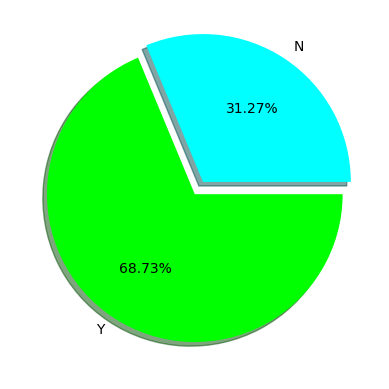

In [6]:
# Checking whether the dataset is imbalanced or not
plt.pie(df['Loan_Status'].value_counts(), labels = df['Loan_Status'].unique(), autopct='%0.2f%%',
        shadow=True, explode=(0, 0.1), counterclock=False, colors=['lime', 'cyan'])
plt.show()

In [7]:
# Getting some information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [8]:
# Extracting numerical features & categorical features from the dataset using a custom made module
num_feature_list = fz.get_num_col(df)
cat_feature_list = fz.get_cat_col(df, ignore_cols='Loan_Status')

print(num_feature_list)
print(cat_feature_list)

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area']



## Outlier analysis


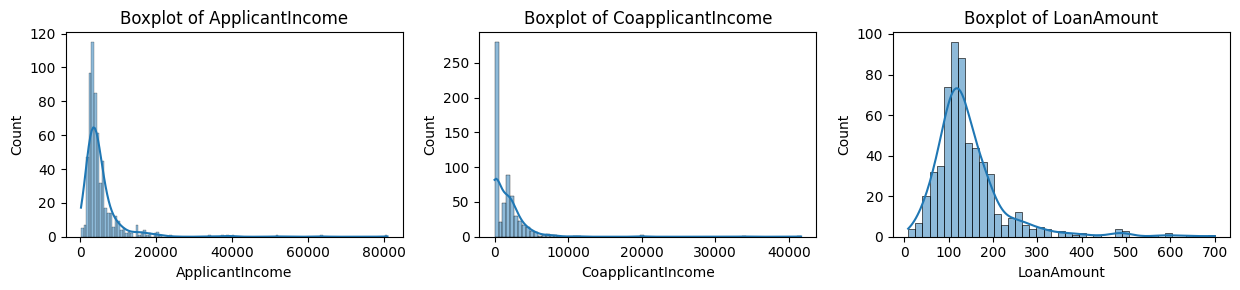

In [9]:
# Plotting scatter plot of all the numerical features

import math

# Number of features
n_features = len(num_feature_list)

# Calculate number of rows and columns needed for subplots
n_cols = 3  # Number of columns for subplots
n_rows = math.ceil(n_features / n_cols)

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4 + 0.5, n_rows * 4 - 1))

# Flatten axs array if it's multidimensional
axs = axs.flatten()

# Plot on each subplot
for i, feature in enumerate(num_feature_list):
    sns.histplot(df[feature], kde=True, ax=axs[i])
    axs[i].set_title('Boxplot of ' + feature)

# Turn off any unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

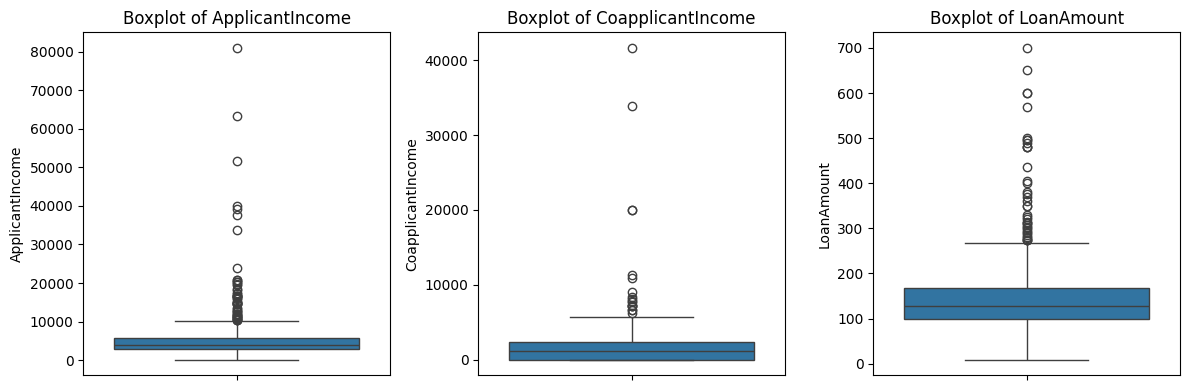

In [10]:
# Plotting box-plot for identifying outliers

import math

# Number of features
n_features = len(num_feature_list)

# Calculate number of rows and columns needed for subplots
n_cols = 3  # Number of columns for subplots
n_rows = math.ceil(n_features / n_cols)

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))

# Flatten axs array if it's multidimensional
axs = axs.flatten()

# Plot on each subplot
for i, feature in enumerate(num_feature_list):
    sns.boxplot(df[feature], orient='v', ax=axs[i])
    axs[i].set_title('Boxplot of ' + feature)

# Turn off any unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

## Missing value analysis

In [11]:
# Calculate the percentage of missing values in numerical features
num_miss_pct = df[num_feature_list].isna().mean()*100

# Filter out categorical features with no missing values
num_miss_pct = num_miss_pct[num_miss_pct > 0]

# Print the percentage of missing values for each numerical features with missing values
for index, value in num_miss_pct.items():
    print(f"{index}: {round(value, 2)}%")

# List of numerical features that have missing values
num_feature_with_na = num_miss_pct.index.to_list()

LoanAmount: 3.58%


In [12]:
# Calculate the percentage of missing values in categorical features
cat_miss_pct = df[cat_feature_list].isna().mean() * 100

# Filter out categorical features with no missing values
cat_miss_pct = cat_miss_pct[cat_miss_pct > 0]

# Print the percentage of missing values for each categorical feature with missing values
for feature, pct in cat_miss_pct.items():
    print(f"{feature}: {round(pct, 2)}%")

# List of categorical features that have missing values
cat_features_with_na = cat_miss_pct.index.to_list()

Gender: 2.12%
Married: 0.49%
Dependents: 2.44%
Self_Employed: 5.21%
Loan_Amount_Term: 2.28%
Credit_History: 8.14%


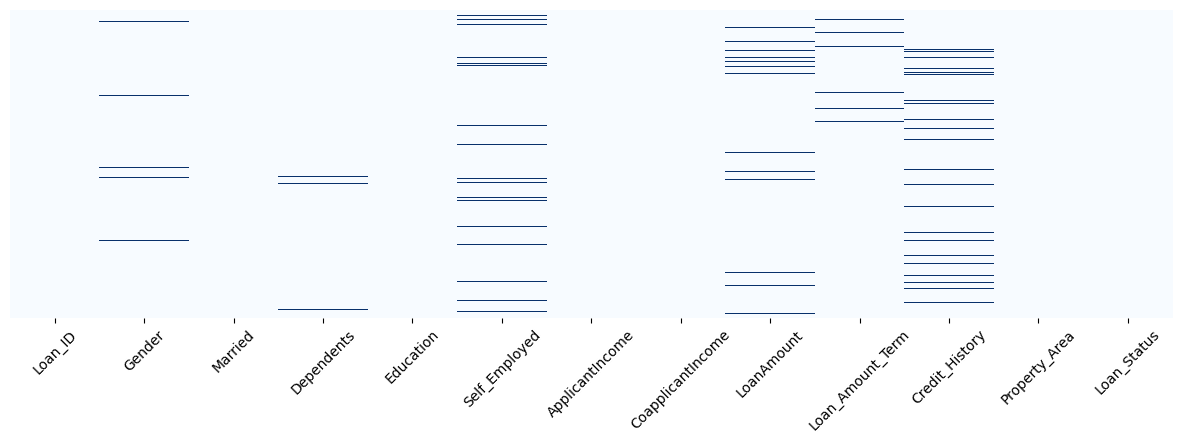

In [13]:
# Visualizing whether the missing values are missing at random or not
plt.figure(figsize=(15, 4))
sns.heatmap(df.isna(), cbar=False, cmap="Blues", yticklabels=False)
plt.xticks(rotation=45)
plt.show()

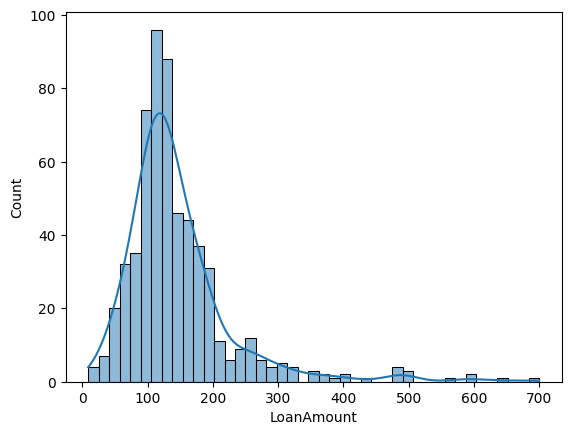

In [14]:
# Visualizing distribution of numerical features that have missing values to decide whether to use mean or median
sns.histplot(df['LoanAmount'], kde=True)
plt.show()

## Assessments
___

1. Useless feature(s) for model prediction:

    - Loan_ID

2. Outlier handling:

    All the numerical features have outliers.

    Since we only have few data points, we can't drop any data points.

    - Percentile based capping
    - Median imputation

    After building predictive model, test accuracy on both these methods

3. Missing value handling:

    Since we only have few data points, we can't drop any data points.

    - Median imputation (Numerical features that are not normally distributed):
        - Loan amount

    - Mode imputation:
        - Categorical feature(s)

4. Change data types:

    - Memory usage
        - Categorical feature(s): category
        - Credit_History: int8

    - Data type comapatibility:
        - Applicant income: float
        
5. Handling imbalanced dataset:

    The dataset is moderately imbalanced. Since we have few data points, oversampling (e.g., using SMOTE or simple duplication) might be better in this scenario.

6. Categorical encoding:
    - OHE: Object type categorical features

    After OHE, convert the new feature's dtype to int8

    


In [16]:
# Deciding which methods to use for handling missing values & outliers using a custom made module
options = fz.get_preprocessing_options(is_normal = False, has_na=True, has_outlier=True)
print(json.dumps(options, indent=4, sort_keys=True))

{
    "missing_value_treatment": [
        "Remove",
        "Median imputation"
    ],
    "outlier_detection_method": "IQR method",
    "outlier_treatment_methods": [
        "Percentile based removing",
        "Percentile based capping",
        "Median imputation"
    ]
}
